# Part 1. Web Scraping from Reddit.com 

## Importing Libraries

In [1]:
# Import Data Manipulation Library
import pandas as pd
import numpy as np
import missingno as msno

# Import API library
import requests
import time
from IPython.display import JSON # Used to display json in clean format

---

## Extracting Title and Thread Info

In [2]:
# Url link of subreddits
url = ["https://www.reddit.com/r/edx.json",
       "https://www.reddit.com/r/coursera.json"]

In [3]:
# Create headers
headers = {'User-agent':'Krisgun Chirasanta'}

In [4]:
# Create an empty list
posts = []
comments = []

# For loop to get the first 50 pages (25 per page)
page = 50

# loop through each url
for u in url:
    
    # Create a starting variable of after to be None
    after = None
    
    # loop through each page
    for i in range(page):
        # Uncomment during debugging
        # print(f"Getting post number: {i+1} of {page}")
        if after == None:
            params = {} # First page no need to set after = name
        else:
            params = {'after': after} # Set after = name of last post

        # Set up url and requests with headers and after as param dictionary
        res = requests.get(u, params=params, headers=headers)

        # Check function of response - 200 = OK, else = check status
        if res.status_code == 200:
            
            # Get the post details
            # Get the response
            mac_json = res.json()

            # Add response of each children to `posts`
            posts.extend(mac_json['data']['children'])

            # Set after variable to the name of last post
            after = mac_json['data']['after']
            
            # Get top 5 comments from those posts
            # Get permalinks
            links = [post['data']['permalink'] for post in \
                    mac_json['data']['children']]
            
            # loop through each permalink on current page
            for link in links:
                
                # get url and response.json()
                url_cmt = 'https://www.reddit.com'+link[:-1]+'.json'
                res = requests.get(url_cmt, headers=headers)
                res_cmt = res.json()
                
                # then get top 5 comments from each res and extend to cmt list
                comments.extend(res_cmt[1]['data']['children'][:1])
                
        else:
            # If error print out status_code and break loop
            print(res.status_code) # uncomment during debugging
            break

        # Put sleep time of 1 second
        time.sleep(1)
        
print('done')

done


---

## Convert to DataFrame

In [39]:
# List of features to extract from `posts`
features = ['name','title','selftext','ups','upvote_ratio',\
            'permalink','subreddit']

# Crate empty dictionary
df_dict = {}

# Looping through feature and store in df_dict
for feat in features:
    df_dict[feat] = [post['data'][feat] for post in posts]

# Transform to a dataframe
df = pd.DataFrame(df_dict)

In [40]:
# List of features to extract from `comments`
features = ['link_id','subreddit','body']

# Crate empty dictionary
cmt_dict = {}

# Looping through feature and store in df_dict
for feat in features:
    cmt_dict[feat] = [comment['data'][feat] for comment in comments]

# Transform to a dataframe
cmt_df = pd.DataFrame(cmt_dict)
cmt_df.columns = ['name','subreddit','title']

---

## Post DataFrame

In [41]:
# Check head of dataframe
df.head(2)

,name,title,selftext,ups,upvote_ratio,permalink,subreddit
0,t3_y39l65,After 8 years of inactivity and unsubscribing ...,I haven't used that site since 2014 according ...,5,0.69,/r/edX/comments/y39l65/after_8_years_of_inacti...,edX
1,t3_y144xh,How to do a Masters in a completely unrelated ...,"Hi guys,\n\nI'm close to finishing my Bachelor...",6,0.81,/r/edX/comments/y144xh/how_to_do_a_masters_in_...,edX


In [42]:
# Dropping some duplicates
df.drop_duplicates(subset='name',inplace=True)

In [43]:
# Check shape
df.shape

(1994, 7)

In [44]:
# Check types
df.dtypes

name             object
title            object
selftext         object
ups               int64
upvote_ratio    float64
permalink        object
subreddit        object
dtype: object

In [45]:
# Check selftext
df['selftext'] = df['selftext'].fillna('empty',inplace=True)

In [46]:
# Uncapitalize target varible
df['subreddit'] = df['subreddit'].apply(lambda x : x.lower())

In [47]:
# Check head
df.head()

,name,title,selftext,ups,upvote_ratio,permalink,subreddit
0,t3_y39l65,After 8 years of inactivity and unsubscribing ...,None,5,0.69,/r/edX/comments/y39l65/after_8_years_of_inacti...,edx
1,t3_y144xh,How to do a Masters in a completely unrelated ...,None,6,0.81,/r/edX/comments/y144xh/how_to_do_a_masters_in_...,edx
2,t3_y09o1m,The consequences of failing a course after get...,None,9,0.81,/r/edX/comments/y09o1m/the_consequences_of_fai...,edx
3,t3_xxluk0,Auditing a Course,None,2,0.67,/r/edX/comments/xxluk0/auditing_a_course/,edx
4,t3_xtszjt,APA Format Citation Guide,None,3,0.81,/r/edX/comments/xtszjt/apa_format_citation_guide/,edx


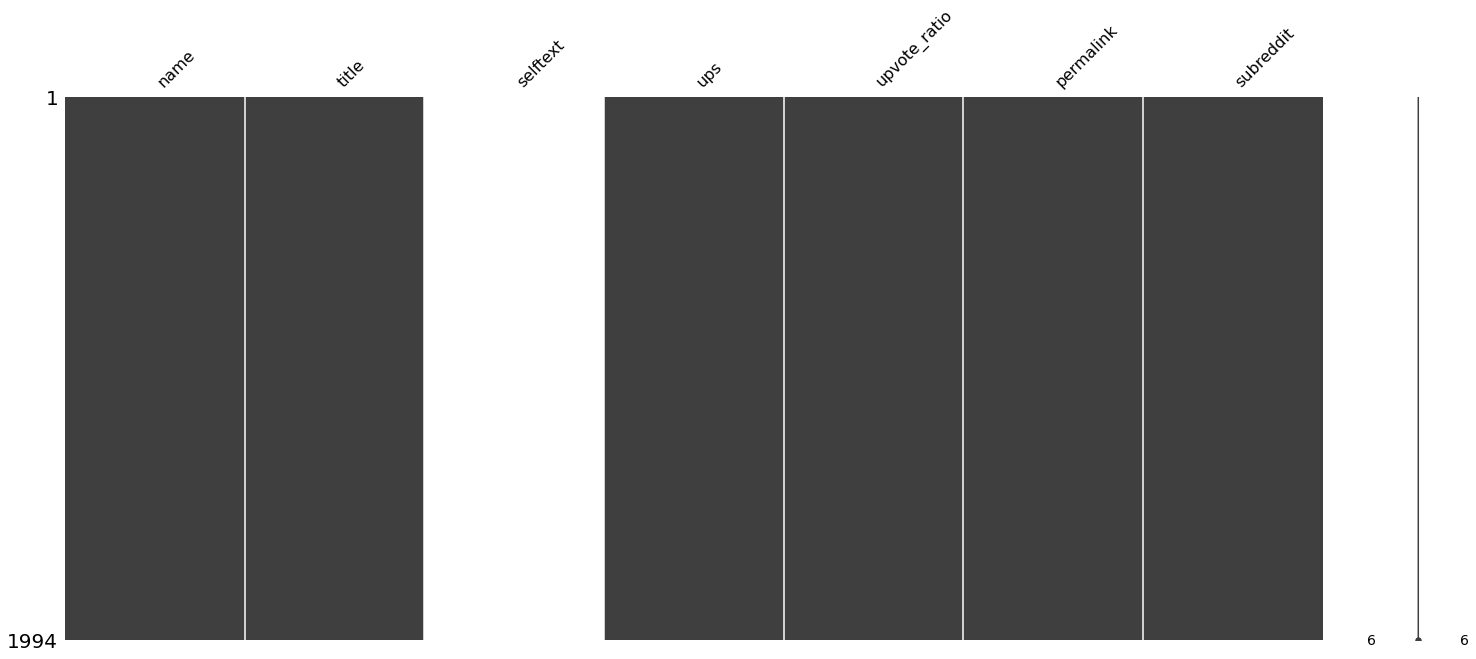

In [48]:
# Check for missing values
msno.matrix(df);

# No missing values

---

## Comments DataFrame

In [49]:
# Check shape
cmt_df.shape

(1957, 3)

In [50]:
cmt_df['subreddit'] = cmt_df['subreddit'].apply(lambda x : x.lower())

In [51]:
# Drop duplicates for comments
cmt_df.drop_duplicates(subset='name',inplace=True)

In [52]:
# Check subreddit count
cmt_df['subreddit'].value_counts()

coursera    813
edx         770
Name: subreddit, dtype: int64

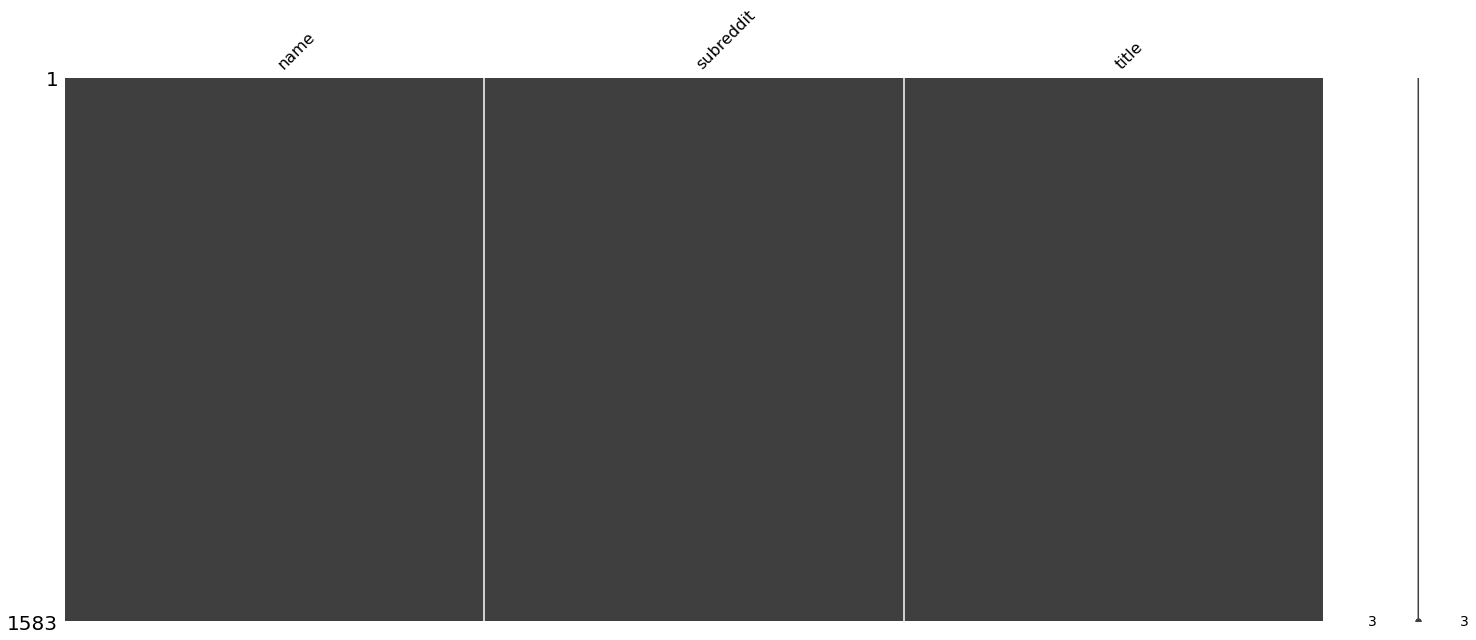

In [53]:
# Check missing value
msno.matrix(cmt_df);

In [54]:
cmt_df.head()

,name,subreddit,title
0,t3_y09o1m,edx,"Financial aid just gives u a discount, you sti..."
1,t3_xxluk0,edx,Not necessarily. Assignments are only for cert...
2,t3_xtm1ea,edx,You can just access archived courses even if n...
3,t3_xsaqli,edx,Cs50 python is more about learning the python ...
4,t3_xseepw,edx,I’m taking it. I don’t like it but I will comp...


---

## Save to CSV

In [55]:
# Export to csv
df.to_csv('../datasets/coursera_edx_posts_f.csv')
cmt_df.to_csv('../datasets/coursera_edx_comments_f.csv')